<a href="https://colab.research.google.com/github/Gr8eye/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/Meghan_Felker_Build2_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Births
***
During my first build week (when I determined that the world's fertility is in decline) I noticed that fertility declines and population still rises but the number of births were a bit more erratic period to period. The quesiton developed about what sort of things determined the number of births period to period. Could I create a model that could accurately predict the number of births per period from certain features?


## **Outline**
___________________
*Outline/Checklist per the Build 2 rubric*
__________________
>
#### **I. Student also explains: Why & how they chose their target, metric, and baseline. How they avoided leakage. When & why the model is (or is not) useful**:
>
  1. ☒ Why did I choose Births as my target? How? 
  
  2. ☒ Why did I choose to use the Regression Metrics function? How?

  3. ☒ Why did I choose Linear Regression for my baseline?

  4. ☒ How did I avoid leakage?

  5. ☒ When is the model useful?(if it is useful)

  6. ☒ Why is the model useful?(if it is useful)

#### **II. Fit any linear regression or classification model (student uses hyper-parameter tuning to improve performance of linear model):**
>
  1. ☒ Fit linear regression model 

  2. ☒ Improve performance with hyper-parameter tuning

#### **III.Student uses hyper-parameter tuning to improve performance of tree-based model:**

  1. ☒ Fit a tree-based model

  2. ☒ Improve model performance with hyper-parameter tuning

#### **IV.Student publishes a blog post(or produces an app). Student writes [300+ - 600+] words (not including code). If writing blog post, student reports baseline score, validation scores from 2+ models, and test score from 1 selected model:**
>
  1. ☒ Publish blog post containing no less than 300 words

  2. ☒ What is the baseline score?

  3. ☒ What are the validation scores?

  4. ☒ What is the test score for your favourite model?

#### **V. Student makes 5+ visualizations to explain their model:**
>
  1. ☒ Create visualizations to explain the model

  2. ☒ Create visualizations to explain the data 

#### **VI. Notebooks are also well organized with Markdown headings and comments:**
>
  1. ☒ Create notebook headings

  2. ☒ Keep code **clean** and **organized**

  3. ☒ **Comments! Comments! Comments!**

#### **VII. If there is time…else for curiousity**
>
  1. ☐ Create an app 

  2. ☐ Explore data using classification model predicting if a country ‘s fertility would be declining based on newly engineered ‘fertility_state’ column



 

----------------
**Imported libraries to be used throughout notebook**:


In [1]:
%%capture
import sys
# Install packages in Colab
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install dalex

In [2]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import category_encoders as ce
import seaborn as sns
import dalex as dx # may not have time

from pandas_profiling import ProfileReport
from pdpbox import pdp

import sklearn 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, max_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

import eli5
from eli5.sklearn import PermutationImportance

from lightgbm import LGBMRegressor, plot_tree
from xgboost import XGBRegressor

import yellowbrick
from yellowbrick.features import Rank1D, Rank2D
from yellowbrick.model_selection import LearningCurve, validation_curve, CVScores
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.features import RFECV


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Functions that may be used**:
_________________

In [3]:
# function to print regression metrics
def RM(true, pred,data):
  ''' Upon receiving the true data and predicted data, prints various 
  regression metrics to provide descriptions of model performance'''

  # average squared difference 
  mse = mean_squared_error(y_true=true,y_pred= pred)
  # error of a model
  rmse = np.sqrt(mse)
  # measure of errors between observations 
  mae = mean_absolute_error(true,pred)
  # measure of how close the data is to the fitted regression line
  R2 = r2_score(true,pred)
  # measure the discrepancy between a model and actual data
  evs = explained_variance_score(true,pred)
  # maximum difference between the point estimate and the actual parameter
  me = max_error(true,pred)
  # R2 score adjusted to predictors 
  AdR2 = float(1-(1-R2)*(len(true)- 1)/(len(true)- data.columns.nunique() - 1))

  print(f'Mean Squared Error: {mse:.2f}')
  print(f'Root Mean Squared Error: {rmse:.2f}')
  print(f'Mean Absolute Error: {mae:.2f}')
  print(f'R^2: {R2}')
  print(f'Adjusted R^2: {AdR2}')
  print(f'Explained Variance Score: {evs}')
  print(f'Max Error:{me}')

# function to compare regression metrics results
def RMComparison(data,true, pred, data2,true2, pred2):

  ''' Upon receiving the x and y values of two models 
  returns results of the differences between the two'''

  # mean square error
  mse = mean_squared_error(true,pred) - mean_squared_error(true2,pred2)
  # root mean square error
  rmse = np.sqrt(mean_squared_error(true,pred)) - np.sqrt(mean_squared_error(true2,pred2))
  # mean absolute error
  mae = mean_absolute_error(true,pred) - mean_absolute_error(true2,pred2)
  # R2 score
  R2 = r2_score(true,pred) - r2_score(true2,pred2)
  # Adjusted R2 score
  AdR2 = float(1-(1-(r2_score(true,pred)))*(len(true)- 1)/(len(true)- data.columns.nunique() - 1)) - float(1-(1-(r2_score(true2,pred2)))*(len(true2)- 1)/(len(true2)- data.columns.nunique() - 1))
  # Explained Variance score
  EVS = explained_variance_score(true,pred) - explained_variance_score(true2,pred2)
  # max error
  ME  = max_error(true,pred) - max_error(true2,pred2)

  print(f'Mean Squared Error Difference: {mse:.2f}')
  print(f'Root Mean Squared Error Difference: {rmse:.2f}')
  print(f'Mean Absolute Error Difference: {mae:.2f}')
  print(f'R^2 Score Difference: {R2}')
  print(f'Adjusted R^2 Difference: {AdR2}')
  print(f'Explained Variance Score Difference: {EVS}')
  print(f'Max Error Difference:{ME}')

In [4]:
# Creating RMComparison table for better comprehensibility

def RMCViz(data,true, pred, data2,true2, pred2):

  ''' Upon receiving the y values and prediction values of two models 
  returns results of the differences between the two in a colored dataframe that 
  shows performance improvement based on differences between the metric scores
  '''

  # mean square error
  mse = mean_squared_error(true2,pred2) - mean_squared_error(true,pred)
  # root mean square error
  rmse = np.sqrt(mean_squared_error(true2,pred2)) - np.sqrt(mean_squared_error(true,pred))
  # mean absolute error
  mae = mean_absolute_error(true2,pred2) - mean_absolute_error(true,pred)
  # R2 score
  R2 = r2_score(true2,pred2) - r2_score(true,pred)
  # Adjusted R2 score
  AdR2 =  float(1-(1-(r2_score(true2,pred2)))*(len(true2)- 1)/(len(true2)- data.columns.nunique() - 1)) - float(1-(1-(r2_score(true,pred)))*(len(true)- 1)/(len(true)- data.columns.nunique() - 1))
  # Explained Variance score
  EVS = explained_variance_score(true2,pred2) - explained_variance_score(true,pred)
  # max error
  ME  = max_error(true2,pred2) - max_error(true,pred) 

  def regressionmetrics(data,true,pred):
    # average squared difference 
    mse = mean_squared_error(y_true=true,y_pred= pred)
    # error of a model
    rmse = np.sqrt(mse)
    # measure of errors between observations 
    mae = mean_absolute_error(true,pred)
    # measure of how close the data is to the fitted regression line
    R2 = r2_score(true,pred)
    # measure the discrepancy between a model and actual data
    evs = explained_variance_score(true,pred)
    # maximum difference between the point estimate and the actual parameter
    me = max_error(true,pred)
    # R2 score adjusted to predictors 
    AdR2 = float(1-(1-R2)*(len(true)- 1)/(len(true)- data.columns.nunique() - 1))
    return [f'{mse:.5f}',f'{rmse:.5f}',f'{mae:.5f}',f'{R2:.5f}',f'{AdR2:.5f}',
            f'{evs:.5f}',f'{me:.5f}']

  
  # dictionary of the values for the dataframe
  d = {'Mean Squared Error': [f'{mse:.5f}'], 
       'Root Mean Squared Error': [f'{rmse:.5f}'],
       'Mean Absolute Error':[f'{mae:.5f}'],
       'R^2 Score':[f'{R2:.5f}'],
       'Adjusted R^2':[f'{AdR2:.5f}'],
       'Explained Variance Score':[f'{EVS:.5f}'],
       'Max Error':[f'{ME:.5f}']}
  # create dataframe from data
  df = pd.DataFrame(data=d)

  # transpose for readability
  df = df.T

  # Remove '0' column name to create 'Metrics Comparison Differences' column along with RM results
  df['Regression Metrics Model A'] = regressionmetrics(data,true,pred)
  df['Regression Metrics Model B'] = regressionmetrics(data2,true2,pred2)
  df = df.rename(columns= {0 :'Metrics Comparison Differences'})
  df = df[['Regression Metrics Model A','Regression Metrics Model B', 'Metrics Comparison Differences']]
  
  # change dtype of dataframe
  df = df.astype(float)

  # Part Two Creating visual effects 
  def highlight_row(d,column):
    if d[column] < 0.00000:
        return ['background-color: #db5142']*len(d)
    elif d[column] == 0.00000:
        return ['background-color: white']*len(d)
    else:
        return ['background-color: #5bcc41']*len(d)

  return df.style.apply(highlight_row, axis=1, column='Metrics Comparison Differences')


## Data Exploration: 
--------------

In [5]:
# Load in dataset
df = pd.read_csv('https://raw.githubusercontent.com/Gr8eye/Gr8eye.github.io/master/Total_Population_Period_Indicators.csv',
                 index_col='MidPeriod')
# Creating Binary column indicating if fertility is in decline 
# 1 is yes, 0 no or unchanged
diffs = df['Total Fertility'].diff()
df = df.assign(fertility_declined=np.where(diffs < 0, 1, 0 ))
# change index to mp_year nee Midperiod
df.index.rename('mp_year',inplace=True)
df

,Unnamed: 0,LocID,Location,Time Period,Total Fertility,NRR(surviving daughters),Crude Birth Rate,Births,Life Expectancy(birth),LExMale,LExFemale,Infant Mortality Rate,Under-five Mortality,Crude Death Rate,Deaths,DeathsMale,DeathsFemale,Net Migration Rate(pK),Net Migrants(K),GrowthRate,Natural Increase Rate,Sex ratio(m per f births,Mean Age Childbearing(f),PopFemale,PopMale,PopTotal,PopDensity,fertility_declined
mp_year,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1953,0,4,Afghanistan,1950-1955,7.450,1.636,50.314,2015.476,28.61,27.94,29.43,275.866,405.090,36.862,1476.605,794.020,682.585,-0.499,-20.000,1.296,13.452,1.060,29.835,3821.348,4218.336,8039.684,12.315,0
1958,1,4,Afghanistan,1955-1960,7.450,1.765,50.998,2201.589,31.13,30.43,31.97,253.647,374.138,33.718,1455.605,783.110,672.495,-0.463,-20.000,1.683,17.280,1.060,29.835,4176.941,4503.156,8680.097,13.295,0
1963,2,4,Afghanistan,1960-1965,7.450,1.899,51.477,2439.130,33.74,32.99,34.64,230.194,341.957,30.808,1459.784,777.437,682.347,-0.422,-20.000,2.026,20.669,1.060,29.835,4636.170,4907.030,9543.200,14.618,0
1968,3,4,Afghanistan,1965-1970,7.450,2.017,51.646,2728.221,36.15,35.37,37.06,211.072,314.708,28.223,1490.896,790.745,700.151,-0.379,-20.000,2.307,23.423,1.060,29.835,5202.606,5434.458,10637.064,16.293,0
1973,4,4,Afghanistan,1970-1975,7.450,2.141,51.234,3056.451,38.74,37.92,39.67,191.642,286.630,25.495,1520.938,802.414,718.524,-0.335,-20.000,2.544,25.739,1.060,29.835,5951.120,6157.843,12108.963,18.548,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,7627,716,Zimbabwe,2005-2010,3.885,1.512,35.220,2181.357,45.02,43.34,46.68,62.686,96.286,16.915,1047.650,521.294,526.356,-8.278,-512.676,1.003,18.305,1.020,27.877,6477.094,5902.459,12379.553,32.001,0
2013,7628,716,Zimbabwe,2010-2015,4.090,1.761,36.445,2415.589,56.71,54.88,58.26,51.221,70.933,10.194,675.684,323.126,352.558,-9.399,-622.997,1.686,26.251,1.020,27.960,7001.157,6349.221,13350.378,34.510,0
2018,7629,716,Zimbabwe,2015-2020,3.626,1.620,30.845,2211.423,60.83,59.16,62.22,38.740,51.246,8.074,578.844,273.627,305.217,-8.150,-584.288,1.463,22.771,1.020,28.203,7559.693,6879.119,14438.812,37.324,1


In [6]:
# Correlation table to check for features unusually correlated with Births
# Leakage check one
df.corr()

,Unnamed: 0,LocID,Total Fertility,NRR(surviving daughters),Crude Birth Rate,Births,Life Expectancy(birth),LExMale,LExFemale,Infant Mortality Rate,Under-five Mortality,Crude Death Rate,Deaths,DeathsMale,DeathsFemale,Net Migration Rate(pK),Net Migrants(K),GrowthRate,Natural Increase Rate,Sex ratio(m per f births,Mean Age Childbearing(f),PopFemale,PopMale,PopTotal,PopDensity,fertility_declined
Unnamed: 0,1.000000,0.126690,0.035619,0.049049,0.027552,0.083345,-0.007368,-0.008240,-0.005441,0.001786,0.002113,-0.004780,0.079705,0.079601,0.079773,0.009614,0.000467,0.027407,0.036352,-0.040937,0.030808,0.078898,0.076674,0.074576,-0.023388,0.009345
LocID,0.126690,1.000000,-0.018191,-0.042183,-0.006990,0.349902,-0.050572,-0.048896,-0.051980,0.074841,0.061842,0.022538,0.339482,0.339806,0.338917,0.012125,-0.075898,0.009010,-0.020365,0.171330,-0.066170,0.326534,0.324994,0.340091,-0.087145,0.144169
Total Fertility,0.035619,-0.018191,1.000000,0.947370,0.983822,-0.026479,-0.878907,-0.862902,-0.887643,0.858983,0.858352,0.632857,-0.078312,-0.080097,-0.076276,-0.050887,-0.095700,0.713911,0.878185,-0.366239,0.336256,-0.161623,-0.158142,-0.159875,-0.112642,-0.201110
NRR(surviving daughters),0.049049,-0.042183,0.947370,1.000000,0.926462,-0.046548,-0.729365,-0.714381,-0.737235,0.681679,0.663777,0.379474,-0.111123,-0.112176,-0.109884,-0.049454,-0.103613,0.767387,0.940102,-0.356688,0.305017,-0.174548,-0.171272,-0.172905,-0.114052,-0.074537
Crude Birth Rate,0.027552,-0.006990,0.983822,0.926462,1.000000,-0.005320,-0.910672,-0.897149,-0.917208,0.874550,0.871301,0.609647,-0.075568,-0.076566,-0.074409,-0.073771,-0.127895,0.727406,0.910191,-0.358069,0.255076,-0.150655,-0.146758,-0.148696,-0.112709,-0.180947
Births,0.083345,0.349902,-0.026479,-0.046548,-0.005320,1.000000,-0.067764,-0.054524,-0.078954,0.085547,0.070177,-0.019299,0.922801,0.927863,0.916606,-0.003621,-0.377816,0.000301,0.003547,0.331068,-0.124402,0.922531,0.924822,0.923757,-0.038314,0.134834
Life Expectancy(birth),-0.007368,-0.050572,-0.878907,-0.729365,-0.910672,-0.067764,1.000000,0.996916,0.997463,-0.949806,-0.950813,-0.773516,-0.002939,-0.001851,-0.004149,0.081298,0.125577,-0.557435,-0.714805,0.284401,-0.122073,0.085866,0.082442,0.084141,0.126880,0.239635
LExMale,-0.008240,-0.048896,-0.862902,-0.714381,-0.897149,-0.054524,0.996916,1.000000,0.988903,-0.939478,-0.939908,-0.769638,0.010209,0.011214,0.009082,0.085915,0.112837,-0.542380,-0.700215,0.289666,-0.090666,0.096811,0.094060,0.095427,0.129967,0.242615
LExFemale,-0.005441,-0.051980,-0.887643,-0.737235,-0.917208,-0.078954,0.997463,0.988903,1.000000,-0.954617,-0.956178,-0.774250,-0.014487,-0.013277,-0.015825,0.078383,0.135599,-0.565610,-0.722453,0.279231,-0.149532,0.076107,0.072141,0.074107,0.123035,0.236483
Infant Mortality Rate,0.001786,0.074841,0.858983,0.681679,0.874550,0.085547,-0.949806,-0.939478,-0.954617,1.000000,0.988207,0.830698,0.038194,0.036225,0.040365,-0.059161,-0.114533,0.507452,0.640542,-0.246731,0.220394,-0.060237,-0.056619,-0.058412,-0.102958,-0.300896


In [7]:
# quick info report, checking nulls, object types features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7632 entries, 1953 to 2098
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7632 non-null   int64  
 1   LocID                     7632 non-null   int64  
 2   Location                  7632 non-null   object 
 3   Time Period               7632 non-null   object 
 4   Total Fertility           7088 non-null   float64
 5   NRR(surviving daughters)  7088 non-null   float64
 6   Crude Birth Rate          7088 non-null   float64
 7   Births                    7088 non-null   float64
 8   Life Expectancy(birth)    7088 non-null   float64
 9   LExMale                   7088 non-null   float64
 10  LExFemale                 7088 non-null   float64
 11  Infant Mortality Rate     7088 non-null   float64
 12  Under-five Mortality      7088 non-null   float64
 13  Crude Death Rate          7088 non-null   float64
 14  Death

In [8]:
# getting a general feel for the data. 
# possible baseline for Births 57,279.25
# There are outliers (*from the differences between the locations)
df.describe()

,Unnamed: 0,LocID,Total Fertility,NRR(surviving daughters),Crude Birth Rate,Births,Life Expectancy(birth),LExMale,LExFemale,Infant Mortality Rate,Under-five Mortality,Crude Death Rate,Deaths,DeathsMale,DeathsFemale,Net Migration Rate(pK),Net Migrants(K),GrowthRate,Natural Increase Rate,Sex ratio(m per f births,Mean Age Childbearing(f),PopFemale,PopMale,PopTotal,PopDensity,fertility_declined
count,7632.00000,7632.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7632.000000,7088.000000,7088.000000,7088.000000,7.088000e+03,7.088000e+03,7.632000e+03,7632.000000,7632.000000
mean,3815.50000,1034.761006,3.831392,1.534372,27.639051,57279.246641,64.279876,62.067798,66.536494,59.517827,87.951534,11.360619,24977.727445,13181.393661,11796.333783,-0.130939,-214.672219,1.583137,16.278433,1.053711,28.810993,2.452477e+05,2.489027e+05,4.589297e+05,197.301073,0.656447
std,2203.31296,722.570401,1.897975,0.604770,12.934401,119362.543037,12.607073,12.158732,13.112974,52.344031,85.371346,5.500324,53517.256616,28209.979282,25322.540725,7.185746,2824.850320,1.350906,10.526515,0.017371,1.415274,5.437541e+05,5.560014e+05,1.067353e+06,1296.935589,0.474925
min,0.00000,4.000000,0.850000,0.410000,5.558000,1.198000,14.490000,11.880000,18.120000,0.126000,0.231000,1.147000,1.597000,0.808000,0.681000,-70.787000,-24462.517000,-13.839000,-20.979000,1.004000,23.897000,7.923000e+00,9.321000e+00,6.850000e-01,0.060000,0.000000
25%,1907.75000,446.000000,2.079750,0.970000,15.911750,602.718250,55.340000,53.580000,57.050000,16.031250,19.552750,7.508500,287.015000,150.790000,136.603250,-1.400000,-457.890000,0.691000,7.604750,1.050000,27.712000,2.499810e+03,2.478078e+03,3.002168e+03,17.507250,0.000000
50%,3815.50000,903.000000,3.301000,1.457500,25.893000,5639.506000,66.565000,64.045000,69.240000,43.623500,56.928500,9.880500,2716.019000,1410.282000,1289.021000,-0.239000,-17.073000,1.597500,17.738000,1.050000,28.997000,2.588380e+04,2.529137e+04,3.396807e+04,40.265000,1.000000
75%,5723.25000,1586.000000,5.642000,2.039000,39.644750,51853.495500,73.340000,70.500000,76.290000,93.709250,137.602000,13.356750,20751.778250,11056.459000,9867.950000,0.859250,88.075000,2.407250,25.183500,1.060000,29.703250,2.122962e+05,2.065572e+05,3.655863e+05,110.183250,1.000000
max,7631.00000,5501.000000,8.800000,3.653000,58.263000,701277.931000,94.020000,91.140000,96.930000,319.239000,465.517000,61.634000,606048.782000,313187.571000,292861.211000,134.414000,23278.467000,20.939000,42.294000,1.173000,34.997000,5.425119e+06,5.443229e+06,1.086835e+07,42625.503000,1.000000


In [9]:
# limiting dataset to numerical columns. 
df.select_dtypes(include='number')

,Unnamed: 0,LocID,Total Fertility,NRR(surviving daughters),Crude Birth Rate,Births,Life Expectancy(birth),LExMale,LExFemale,Infant Mortality Rate,Under-five Mortality,Crude Death Rate,Deaths,DeathsMale,DeathsFemale,Net Migration Rate(pK),Net Migrants(K),GrowthRate,Natural Increase Rate,Sex ratio(m per f births,Mean Age Childbearing(f),PopFemale,PopMale,PopTotal,PopDensity,fertility_declined
mp_year,,,,,,,,,,,,,,,,,,,,,,,,,,
1953,0,4,7.450,1.636,50.314,2015.476,28.61,27.94,29.43,275.866,405.090,36.862,1476.605,794.020,682.585,-0.499,-20.000,1.296,13.452,1.060,29.835,3821.348,4218.336,8039.684,12.315,0
1958,1,4,7.450,1.765,50.998,2201.589,31.13,30.43,31.97,253.647,374.138,33.718,1455.605,783.110,672.495,-0.463,-20.000,1.683,17.280,1.060,29.835,4176.941,4503.156,8680.097,13.295,0
1963,2,4,7.450,1.899,51.477,2439.130,33.74,32.99,34.64,230.194,341.957,30.808,1459.784,777.437,682.347,-0.422,-20.000,2.026,20.669,1.060,29.835,4636.170,4907.030,9543.200,14.618,0
1968,3,4,7.450,2.017,51.646,2728.221,36.15,35.37,37.06,211.072,314.708,28.223,1490.896,790.745,700.151,-0.379,-20.000,2.307,23.423,1.060,29.835,5202.606,5434.458,10637.064,16.293,0
1973,4,4,7.450,2.141,51.234,3056.451,38.74,37.92,39.67,191.642,286.630,25.495,1520.938,802.414,718.524,-0.335,-20.000,2.544,25.739,1.060,29.835,5951.120,6157.843,12108.963,18.548,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,7627,716,3.885,1.512,35.220,2181.357,45.02,43.34,46.68,62.686,96.286,16.915,1047.650,521.294,526.356,-8.278,-512.676,1.003,18.305,1.020,27.877,6477.094,5902.459,12379.553,32.001,0
2013,7628,716,4.090,1.761,36.445,2415.589,56.71,54.88,58.26,51.221,70.933,10.194,675.684,323.126,352.558,-9.399,-622.997,1.686,26.251,1.020,27.960,7001.157,6349.221,13350.378,34.510,0
2018,7629,716,3.626,1.620,30.845,2211.423,60.83,59.16,62.22,38.740,51.246,8.074,578.844,273.627,305.217,-8.150,-584.288,1.463,22.771,1.020,28.203,7559.693,6879.119,14438.812,37.324,1


In [10]:
# Get Pandas Profiling Report
profile = ProfileReport(df, minimal=True).to_notebook_iframe()
profile

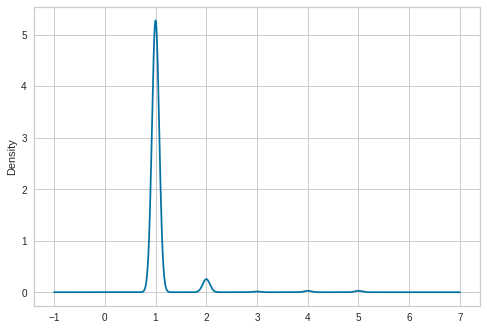

In [11]:
# looking at births distribution 
df.Births.value_counts().plot(kind='kde');

### **Train / Validation / Test Split Data**

In [12]:
# Splitting data into random train / validation / test split 
#*Remember random_state in the future
train,test = train_test_split(df, train_size=0.80, test_size=0.20,random_state=24)
train, val = train_test_split(train,train_size=0.80, test_size=0.20,random_state=24)
train.shape,val.shape,test.shape

((4884, 28), (1221, 28), (1527, 28))

## Preprocessing:
_______________
Transform dataset into something that I can use for my machine learning problem(finding a model to predict births by location data)

### **Wrangling**:
________________

The wrangling would be done by a function('wrangler') that would handle each dataset the same way. 

In [13]:
# defining wrangling function
def wrangler(X):
  '''takes dataset, fixes errors, engineers features, 
  and returns dataset ready for model'''

  # prevent overwriting original
  X = X.copy()

  # renaming columns
  X = X.rename(columns={'Unnamed: 0': 'drop', 'MidPeriod': 'mp_date',
                        'NRR(surviving daughters)':'NRR',
                        'Life Expectancy(birth)':'lex',
                        'Net Migration Rate(pK)':'NMR',
                        'Net Migrants(K)':'Net Migrants',
                        'Mean Age Childbearing(f)':'MAC',
                        'Sex ratio(m per f births':'sex_ratio'})
 

  # fixing column names 
  def standard(d):
    cols = list(d.columns)
    for c in range(len(d.columns)):
      cols[c] = cols[c].replace(' ', '_')
      cols[c] = cols[c].lower()
      cols[c] = cols[c].replace('-','_')
    d.columns = cols
    return d
  # applying to data
  X = standard(X)

  # there are rows missing large portions of the data,
  # but makes up a low portion of the data that I will drop
  X = X.dropna(subset=['births'])

  # creating list of columns that won't be needed due to high cardinality
  # or potential leakage
  dc = ['drop', 'locid', 'location', 'time_period', 'crude_birth_rate',
       'growthrate', 'natural_increase_rate', 'popmale','popfemale']
  # dropping those columns
  X = X.drop(columns=dc)

  return X

# applying function to datasets
Train = wrangler(train)
Val   = wrangler(val)
Test  = wrangler(test)
Train

,total_fertility,nrr,births,lex,lexmale,lexfemale,infant_mortality_rate,under_five_mortality,crude_death_rate,deaths,deathsmale,deathsfemale,nmr,net_migrants,sex_ratio,mac,poptotal,popdensity,fertility_declined
mp_year,,,,,,,,,,,,,,,,,,,
1963,5.050,2.300,538.164,68.81,64.86,72.15,33.579,42.835,5.503,89.612,49.391,40.221,-1.682,-27.385,1.074,29.062,3311.460,3153.771,0
1963,6.200,2.230,141.724,48.32,46.09,50.60,115.331,186.682,17.556,59.282,31.289,27.993,0.000,0.000,1.012,30.542,681.633,0.828,0
2013,1.511,0.723,1003.726,74.94,71.49,78.41,8.352,9.870,12.381,1250.418,650.041,600.377,-2.971,-300.001,1.058,27.380,20132.780,87.469,0
2008,1.750,0.843,949.966,80.10,77.93,82.15,4.297,5.129,8.229,691.913,337.379,354.534,1.019,85.685,1.060,30.606,16862.058,485.854,0
1993,4.939,1.906,18761.885,53.01,50.49,55.64,96.140,149.538,13.241,6683.027,3596.796,3086.231,0.602,303.836,1.020,28.812,102203.493,17.298,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,2.273,1.112,65.533,80.03,77.32,83.75,2.665,3.005,6.210,27.304,15.045,12.259,-1.428,-6.280,1.030,28.290,882.531,353.012,1
1973,2.323,1.086,4407.030,72.22,69.17,75.26,25.833,28.923,9.855,2680.112,1420.696,1259.416,0.071,19.396,1.063,27.969,54619.240,185.691,1
2008,1.985,0.955,1778.094,81.28,79.03,83.52,4.503,5.396,6.613,840.466,430.534,409.932,10.018,1273.215,1.060,30.131,25610.449,3.223,0


## Feature Selection: 
________________
#### **Arrange X matrices and Y target vectors:**

The target of the model will be the births column, the x features are made up of the remaining columns

In [14]:
# I knew my target would be births
target = 'births'
# and features were subject to change, but the initial feeling was to incude the following
features = Train.columns.drop(target)
features

Index(['total_fertility', 'nrr', 'lex', 'lexmale', 'lexfemale',
       'infant_mortality_rate', 'under_five_mortality', 'crude_death_rate',
       'deaths', 'deathsmale', 'deathsfemale', 'nmr', 'net_migrants',
       'sex_ratio', 'mac', 'poptotal', 'popdensity', 'fertility_declined'],
      dtype='object')

In [15]:
# Arranging X and Y
x_train = Train[features]
x_val = Val[features]
x_test = Test[features]

y_train = Train[target]
y_val = Val[target]
y_test = Test[target]

In [16]:
# I became curious about which features SelectKbest would choose
select = SelectKBest(k=10)

encoder = ce.OrdinalEncoder()

Xe = encoder.fit_transform(x_train)
Xte = encoder.fit_transform(x_test)

x_trainS = select.fit_transform(Xe, y_train)
x_testS = select.transform(Xte)
selected_mask = select.get_support()
all_names = x_train.columns
kbfeats = all_names[selected_mask]

# and for a good reason, I found the SelectKbest selections were reasonable
print('Features selected:')
for name in kbfeats:
    print(name)

Features selected:
lex
lexmale
lexfemale
infant_mortality_rate
under_five_mortality
deaths
deathsmale
deathsfemale
net_migrants
poptotal


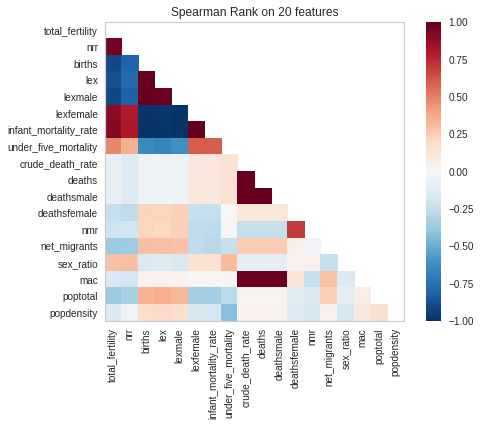

In [17]:
# Instantiate visualizer with the spearman ranking algorithm
visualizer = Rank2D(algorithm='spearman',features=Train.columns)
X = x_train.values
y  = y_train.values
# Fit the data to the visualizer
visualizer.fit(X, y)           
visualizer.transform(X);       
visualizer.set_title(title= 'Spearman Rank on 20 features')

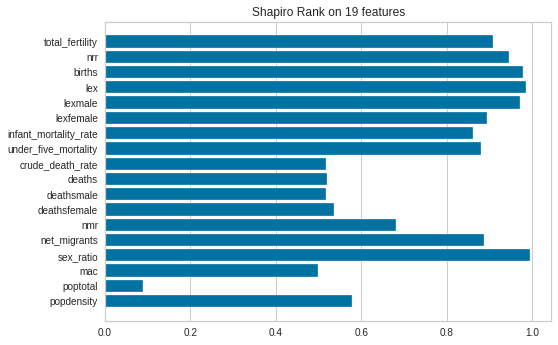

In [18]:
viz = Rank1D(algorithm='shapiro',features=Train.columns)
# Fit the data to the visualizer
viz.fit(X, y)           
viz.transform(X);       
viz.set_title(title= 'Shapiro Rank on 19 features')

## Baseline:
____________
The baseline model will be the performed using a linear regression model

In [19]:
# instantiate 
linmod = LinearRegression(n_jobs=-1)
# choosing X values for this model
feat = ['poptotal']
# arrange
X_Train = Train[feat]
X_Val   = Val[feat]
X_Test  = Test[feat]

Y_Train = Train[target]
Y_Val   = Val[target]
Y_Test  = Test[target]

# fit the model
linmod.fit(X_Train,Y_Train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

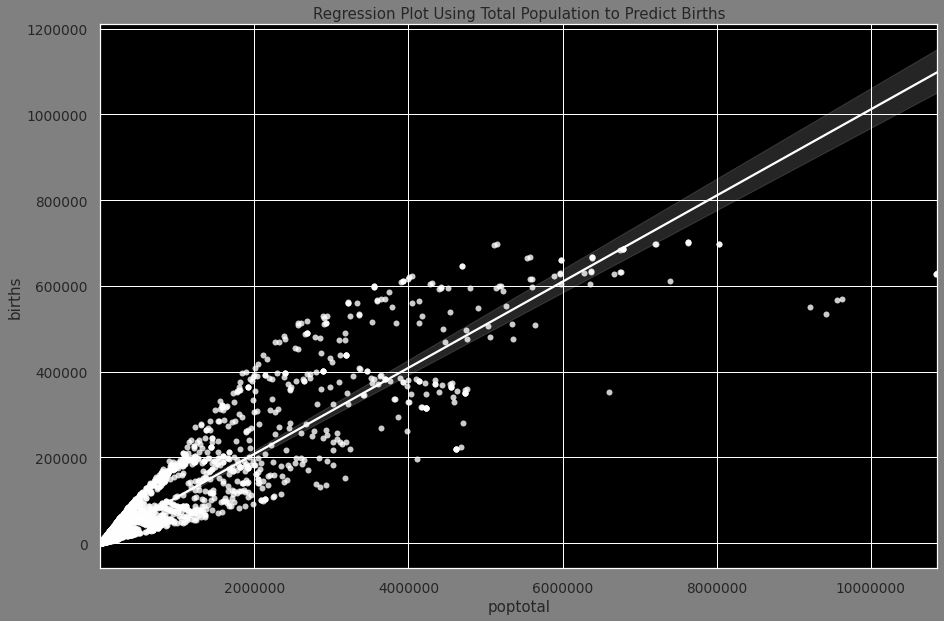

In [20]:
# Plotting baseline
sns.set(font_scale=1.25, rc={'axes.facecolor':'black', 'figure.facecolor':'gray','figure.figsize':(15,10)})
sns.regplot(X_Train,Y_Train,Train, color='white')
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('Regression Plot Using Total Population to Predict Births');

In [21]:
# apply to new data
valpred = linmod.predict(X_Val)
testpred = linmod.predict(X_Test)

In [22]:
# taking a peak at the predictions
Comp= pd.DataFrame()
Comp['true_values'] = Y_Val
Comp['baseline_prediction'] = valpred
Comp

,true_values,baseline_prediction
mp_year,,
1973,13.973,7301.104720
1993,1865.554,8293.319468
2003,66013.631,127815.807640
1993,55997.984,34265.775299
2003,1426.050,7988.557642
...,...,...
1963,760.839,7657.646982
2008,87734.101,146263.247628
1993,57566.101,52999.071120


In [23]:
# Obtain Regression metrics for the model
print('Regression Metrics for Baseline Validation data:')
RM(Y_Val,valpred,X_Val)

Regression Metrics for Baseline Validation data:
Mean Squared Error: 2255924139.00
Root Mean Squared Error: 47496.57
Mean Absolute Error: 23332.54
R^2: 0.8420871916893911
Adjusted R^2: 0.8419471980650022
Explained Variance Score: 0.842432108632568
Max Error:402196.4172210747


In [24]:
print('regression metrics for Test data:')
RM(Y_Test,testpred,X_Test)

regression metrics for Test data:
Mean Squared Error: 2077982072.54
Root Mean Squared Error: 45584.89
Mean Absolute Error: 22749.69
R^2: 0.8684762056035181
Adjusted R^2: 0.868383124361907
Explained Variance Score: 0.8684765063888079
Max Error:469040.7901866704


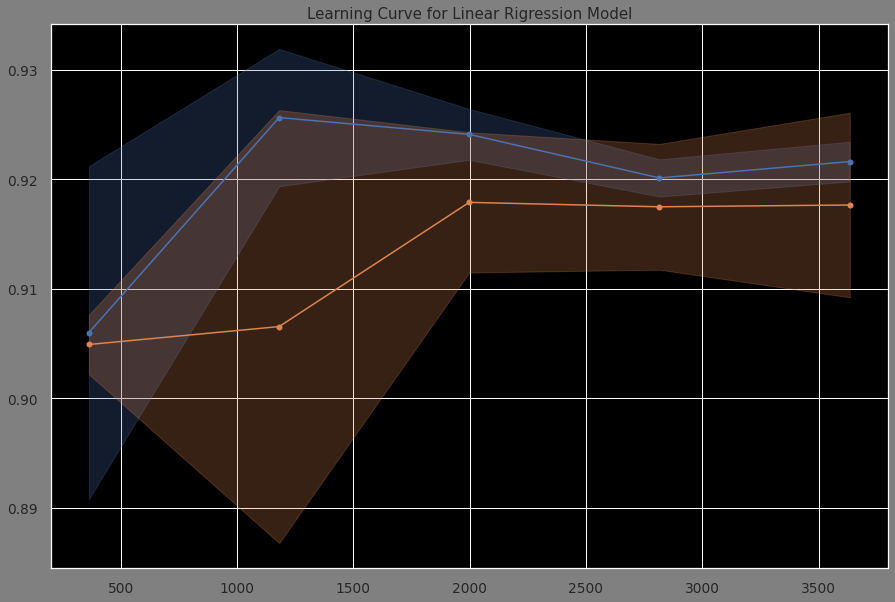

In [25]:
# Learning curve by R^2
visualizer = LearningCurve(linmod, scoring='r2')

visualizer.fit(X, y)
visualizer.set_title(title='Learning Curve for Linear Rigression Model')

## **Lasso Regression:**

In [26]:
# curious about how a simple lasso would do
Lass = Lasso()
# training model
Lass.fit(X_Train,Y_Train)
# Validation prediction
lvpred = Lass.predict(X_Val)
lvpred

array([  7301.10472028,   8293.31946844, 127815.8076393 , ...,
        52999.07111988,   9893.06244726, 269618.30768466])

In [27]:
# Regression metrics for the Lasso
RM(y_val,lvpred, X_Val)

Mean Squared Error: 2255924139.00
Root Mean Squared Error: 47496.57
Mean Absolute Error: 23332.54
R^2: 0.842087191689338
Adjusted R^2: 0.8419471980649491
Explained Variance Score: 0.8424321086325166
Max Error:402196.4172132178


In [28]:
# comparing to baseline
RMCViz(X_Val,Y_Val,valpred,X_Val, y_val,lvpred) # Af

,Regression Metrics Model A,Regression Metrics Model B,Metrics Comparison Differences
Mean Squared Error,2255924138.999600,2255924139.000350,0.000760
Root Mean Squared Error,47496.569760,47496.569760,0.000000
Mean Absolute Error,23332.538860,23332.538860,0.000000
R^2 Score,0.842090,0.842090,-0.000000
Adjusted R^2,0.841950,0.841950,-0.000000
Explained Variance Score,0.842430,0.842430,-0.000000
Max Error,402196.417220,402196.417210,-0.000010


### **Hyper-tuning Lasso Model hyper parameters with GridSearchCV:**

In [29]:
# Arranging search parameters
params = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 25, 1))),
          'fit_intercept': [True,False],
          'max_iter': np.arange(500,1500,100),
          'normalize': [True,False], 
          'positive': [True,False,],
          'precompute': [True,False],
          'random_state': [24,42,32],
          'selection': ['cyclic','random'],
          'warm_start': [True,False]}
# creating gridsearch
search = GridSearchCV(Lass,params,scoring='r2',verbose=10,n_jobs=-1, cv=3, return_train_score=True)

In [30]:
# Fitting to the data to find best parameters
search.fit(X_Train,Y_Train)

Fitting 3 folds for each of 80640 candidates, totalling 241920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1874s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0374s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0714s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1175s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1977s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    4.0s
[Parallel(n

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2....
       16. , 17. , 18. , 19. , 20. , 21. , 22. , 23. , 24. ]),
                         'fit_intercept': [True, False],
                         'max_iter': array([ 500,  600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400]),
                         'normalize': [True, False], 'positive': [True, False],
                         'precompute': [True, False],
                         'random_state': [24, 42, 32],
                         'selection': ['cy

In [31]:
# Print results from Gridsearch with CVMAE 
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', search.best_score_)

Best hyperparameters {'alpha': 5.0, 'fit_intercept': True, 'max_iter': 500, 'normalize': True, 'positive': True, 'precompute': True, 'random_state': 24, 'selection': 'cyclic', 'warm_start': True}
Cross-validation MAE 0.8496151805631941


In [32]:
# Create Pipeline with Lasso model
Lasspipe = make_pipeline(StandardScaler(),
                         Lasso(alpha= 3.0, 
                               fit_intercept= True,
                               max_iter= 500, 
                               normalize= True,
                                positive= True, 
                                precompute= True, 
                                random_state=24,
                                selection= 'cyclic', 
                                warm_start= True))
# train model
Lasspipe.fit(X_Train,y_train)
# predictions
lgvpred = Lasspipe.predict(X_Val)
ltest_pred = Lasspipe.predict(X_Test)

In [33]:
# Compare to baseline
RMCViz(X_Val, Y_Val,valpred,X_Val, y_val,lgvpred)

,Regression Metrics Model A,Regression Metrics Model B,Metrics Comparison Differences
Mean Squared Error,2255924138.999600,2256130830.446980,206691.447380
Root Mean Squared Error,47496.569760,47498.745570,2.175810
Mean Absolute Error,23332.538860,23378.243320,45.704460
R^2 Score,0.842090,0.842070,-0.000010
Adjusted R^2,0.841950,0.841930,-0.000010
Explained Variance Score,0.842430,0.842420,-0.000010
Max Error,402196.417220,400485.583400,-1710.833820


In [34]:
# I suspect that I can get better performance than the gridsearch by mixing intuition(guesswork) with gridsearch results
Lpipe = make_pipeline(StandardScaler(),
                         Lasso(alpha= 3.0, 
                               fit_intercept= True,
                               max_iter= 500,
                                positive= True, 
                                random_state=24,
                                selection= 'random', 
                                warm_start= True))
Lpipe.fit(X_Train,y_train)
lpvpred = Lpipe.predict(X_Val)
RMCViz(X_Val, y_val,lgvpred,X_Val, y_val,lpvpred)

,Regression Metrics Model A,Regression Metrics Model B,Metrics Comparison Differences
Mean Squared Error,2256130830.446980,2255926594.885340,-204235.561640
Root Mean Squared Error,47498.745570,47496.595610,-2.149950
Mean Absolute Error,23378.243320,23333.216910,-45.026420
R^2 Score,0.842070,0.842090,0.000010
Adjusted R^2,0.841930,0.841950,0.000010
Explained Variance Score,0.842420,0.842430,0.000010
Max Error,400485.583400,402171.034600,1685.451200


In [35]:
# Trying with more features
F = ['nrr','lexmale','lexfemale','lex','mac','total_fertility','deaths','poptotal']
X_train = Train[F]
X_val = Val[F]
X_test = Test[F]
X_train

,nrr,lexmale,lexfemale,lex,mac,total_fertility,deaths,poptotal
mp_year,,,,,,,,
1963,2.300,64.86,72.15,68.81,29.062,5.050,89.612,3311.460
1963,2.230,46.09,50.60,48.32,30.542,6.200,59.282,681.633
2013,0.723,71.49,78.41,74.94,27.380,1.511,1250.418,20132.780
2008,0.843,77.93,82.15,80.10,30.606,1.750,691.913,16862.058
1993,1.906,50.49,55.64,53.01,28.812,4.939,6683.027,102203.493
...,...,...,...,...,...,...,...,...
2018,1.112,77.32,83.75,80.03,28.290,2.273,27.304,882.531
1973,1.086,69.17,75.26,72.22,27.969,2.323,2680.112,54619.240
2008,0.955,79.03,83.52,81.28,30.131,1.985,840.466,25610.449


In [36]:
# model with features and gridsearch suggestions
Lgbppipe = make_pipeline(StandardScaler(),
                         Lasso(alpha= 3.0, 
                               fit_intercept= True,
                               max_iter= 500, 
                               normalize= True,
                               positive= True, 
                               precompute= True, 
                               random_state=24,
                               selection= 'cyclic', 
                               warm_start= True))
Lgbppipe.fit(X_train,y_train)
lgbpvpred = Lgbppipe.predict(X_val)
lgbptpred = Lgbppipe.predict(X_test)
RMCViz(X_Val,Y_Val,valpred,X_val,y_val,lgbpvpred)

,Regression Metrics Model A,Regression Metrics Model B,Metrics Comparison Differences
Mean Squared Error,2255924138.999600,1694972709.437910,-560951429.561680
Root Mean Squared Error,47496.569760,41170.046260,-6326.523500
Mean Absolute Error,23332.538860,19640.127390,-3692.411470
R^2 Score,0.842090,0.881350,0.039270
Adjusted R^2,0.841950,0.880510,0.039300
Explained Variance Score,0.842430,0.881450,0.039020
Max Error,402196.417220,493251.165340,91054.748120


In [37]:
# actual values with model predictions
Comp2= pd.DataFrame()
Comp2['true_values'] = np.around(Y_Val)
Comp2['lasso_prediction'] = np.around(lgbpvpred)
Comp2

,true_values,lasso_prediction
mp_year,,
1973,14.0,8705.0
1993,1866.0,13589.0
2003,66014.0,119088.0
1993,55998.0,51473.0
2003,1426.0,16952.0
...,...,...
1963,761.0,17071.0
2008,87734.0,115704.0
1993,57566.0,41305.0


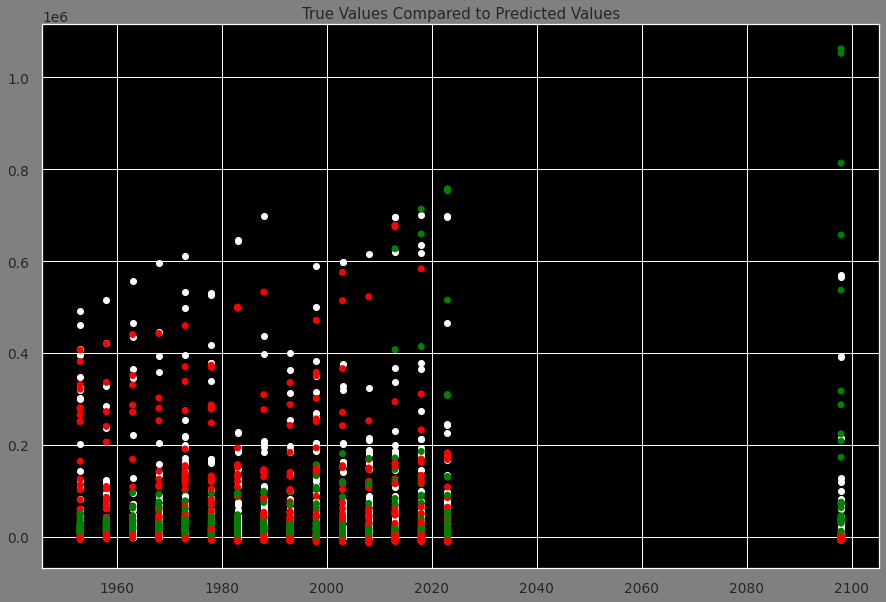

In [38]:
# Set color for every value type
color = ['red' if x > y else 'green' if x < y else 'white' for x,y in zip(Comp2['true_values'],Comp2['lasso_prediction'])] 
# Create scatter plots
plt.scatter(x=Comp2.index, y=Comp2['true_values'], c='white')
plt.scatter(x=Comp2.index, y=Comp2['lasso_prediction'],c=color)
plt.title('True Values Compared to Predicted Values');

## Tree Model:
___________________


In [39]:
# create a pipeline with regression model
pipeline = (LGBMRegressor(boosting_type='dart',
                          learning_rate=0.1, max_depth=-1,
                          n_estimators=100, n_jobs=-1, num_leaves=31, 
                          objective='regression',random_state=24))
pipeline.fit(x_train,y_train)
val_pred = pipeline.predict(x_val)
t_pred   = pipeline.predict(x_test)

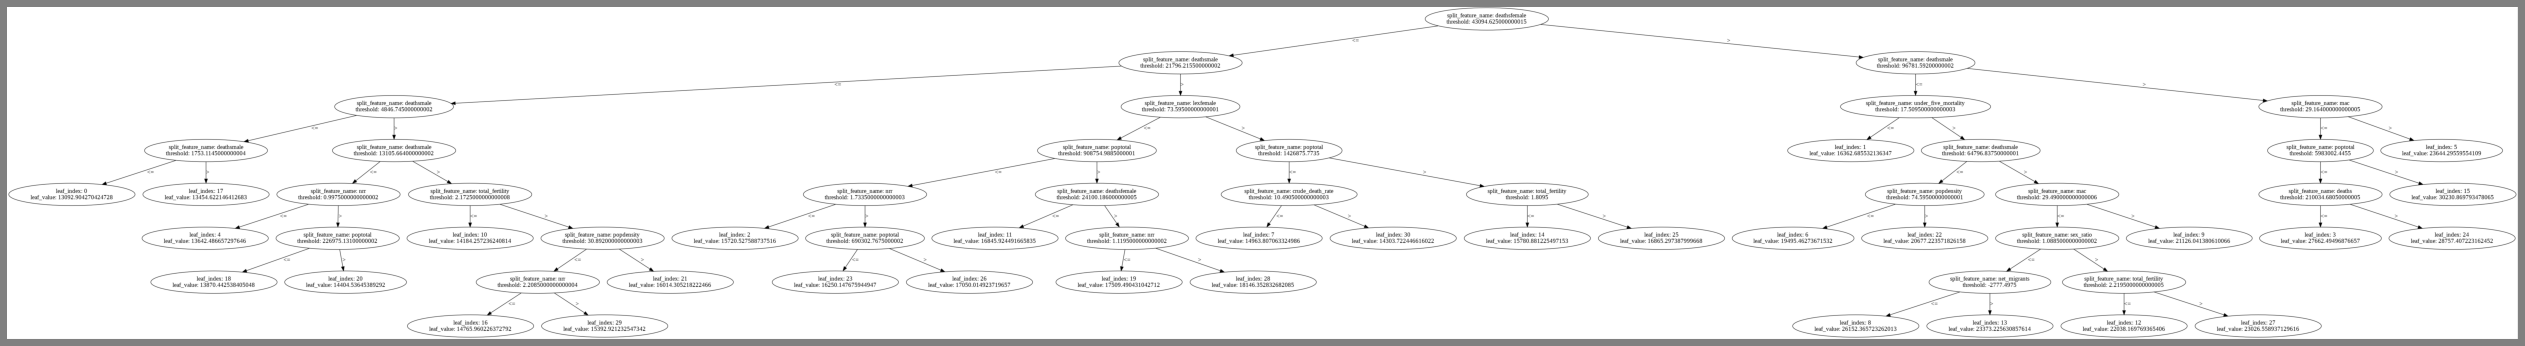

In [40]:
# visualizing tree 
plot_tree(pipeline,figsize=(45,20));

In [41]:
# Permutation importance
perm = PermutationImportance(pipeline,
                             scoring='r2', 
                             n_iter=5, 
                             random_state=24)

perm.fit(x_test.values,y_test.values)
featnames = x_test.columns.to_list()
eli5.show_weights(perm, 
                  top=None,
                  feature_names=featnames)

Weight,Feature
0.3619 ± 0.0253,deathsmale
0.2160 ± 0.0176,deathsfemale
0.0759 ± 0.0069,deaths
0.0632 ± 0.0043,poptotal
0.0200 ± 0.0063,nrr
0.0139 ± 0.0058,mac
0.0101 ± 0.0028,total_fertility
0.0066 ± 0.0016,lexfemale
0.0060 ± 0.0030,crude_death_rate
0.0032 ± 0.0011,under_five_mortality


In [42]:
# Regression Metrics for the tree model

RM(y_val,val_pred,x_val)

Mean Squared Error: 137517860.15
Root Mean Squared Error: 11726.80
Mean Absolute Error: 4854.23
R^2: 0.9903738644783576
Adjusted R^2: 0.9902179054870078
Explained Variance Score: 0.9914505064158066
Max Error:112260.00401449378


In [43]:
RM(Y_Val,valpred,X_Val)

Mean Squared Error: 2255924139.00
Root Mean Squared Error: 47496.57
Mean Absolute Error: 23332.54
R^2: 0.8420871916893911
Adjusted R^2: 0.8419471980650022
Explained Variance Score: 0.842432108632568
Max Error:402196.4172210747


In [44]:
# How does that compare to the baseline model 
RMComparison(X_Val,Y_Val,valpred,x_val,y_val,val_pred)

Mean Squared Error Difference: 2118406278.85
Root Mean Squared Error Difference: 35769.77
Mean Absolute Error Difference: 18478.31
R^2 Score Difference: -0.14828667278896657
Adjusted R^2 Difference: -0.14841813260526893
Explained Variance Score Difference: -0.14901839778323855
Max Error Difference:289936.4132065809


In [45]:
# How does that compare to the baseline Model visual(Validation)
RMCViz(X_Val,y_val,valpred,x_val,y_val,val_pred)

,Regression Metrics Model A,Regression Metrics Model B,Metrics Comparison Differences
Mean Squared Error,2255924138.999600,137517860.146220,-2118406278.853380
Root Mean Squared Error,47496.569760,11726.800930,-35769.768830
Mean Absolute Error,23332.538860,4854.233140,-18478.305720
R^2 Score,0.842090,0.990370,0.148290
Adjusted R^2,0.841950,0.990220,0.148420
Explained Variance Score,0.842430,0.991450,0.149020
Max Error,402196.417220,112260.004010,-289936.413210


In [46]:
# How does that compare to the baseline(test)
RMCViz(X_Val,y_val,valpred,x_test,y_test,t_pred)

,Regression Metrics Model A,Regression Metrics Model B,Metrics Comparison Differences
Mean Squared Error,2255924138.999600,165983989.647570,-2089940149.352030
Root Mean Squared Error,47496.569760,12883.477390,-34613.092370
Mean Absolute Error,23332.538860,5220.973220,-18111.565650
R^2 Score,0.842090,0.989490,0.147410
Adjusted R^2,0.841950,0.989360,0.147540
Explained Variance Score,0.842430,0.990640,0.148200
Max Error,402196.417220,179295.417350,-222900.999870


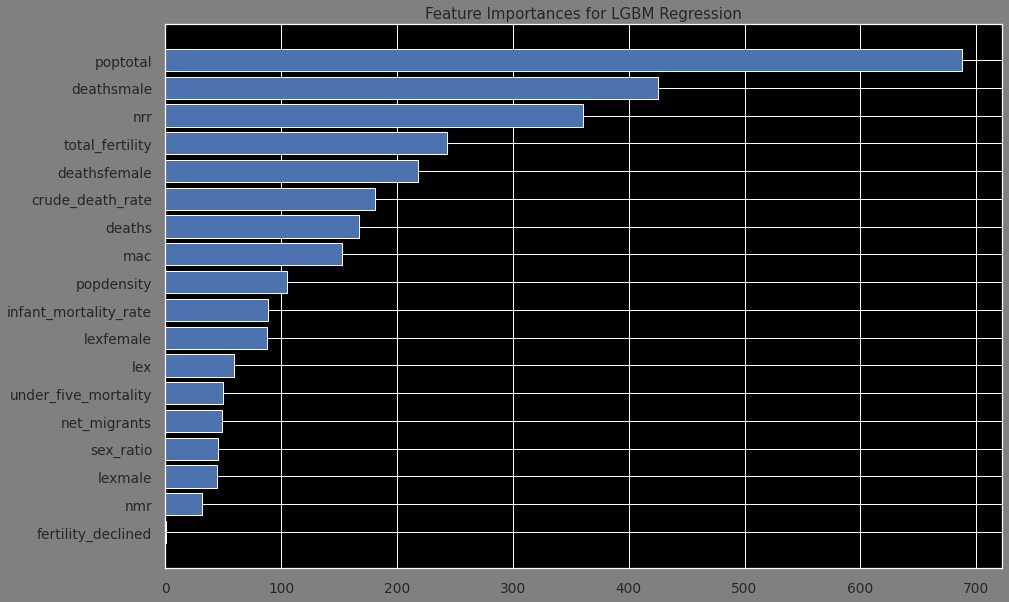

In [47]:
visualizer = FeatureImportances(pipeline,labels=Train.columns.drop('births'),relative=False)
visualizer.fit(X, y);
visualizer.set_title(title='Feature Importances for LGBM Regression')

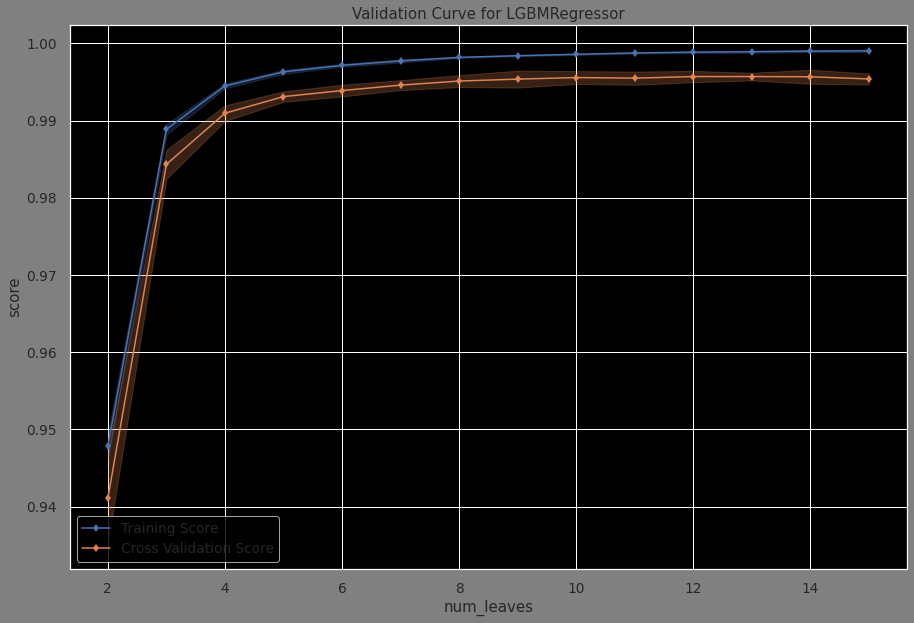

In [48]:
# Validation Curves...
viz = validation_curve(LGBMRegressor(), X, y, param_name='num_leaves',
                       param_range=np.arange(1, 16), cv=5, scoring="r2")

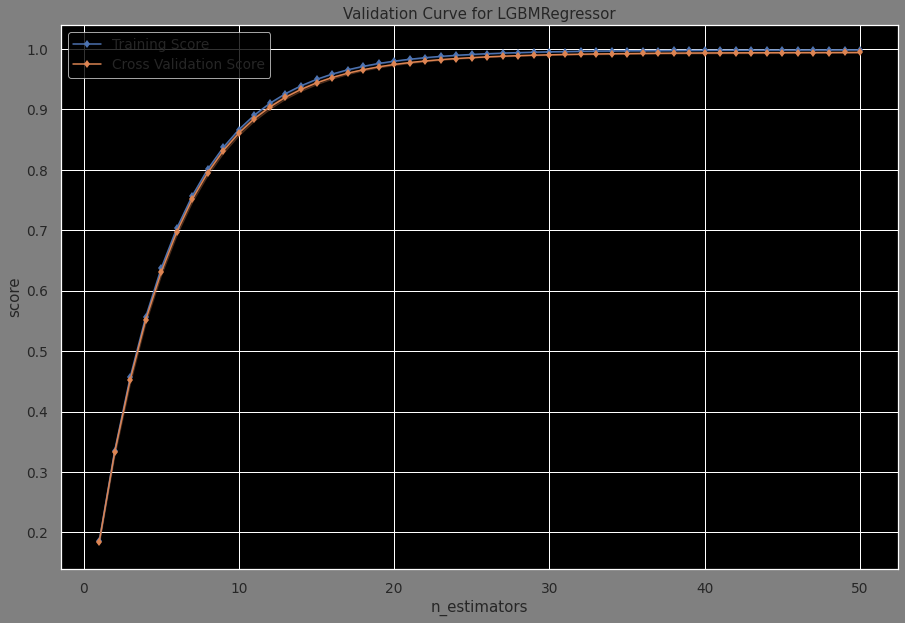

In [49]:
viz = validation_curve(LGBMRegressor(), X, y, param_name='n_estimators',
                       param_range=np.arange(1, 51), cv=5, scoring="r2")

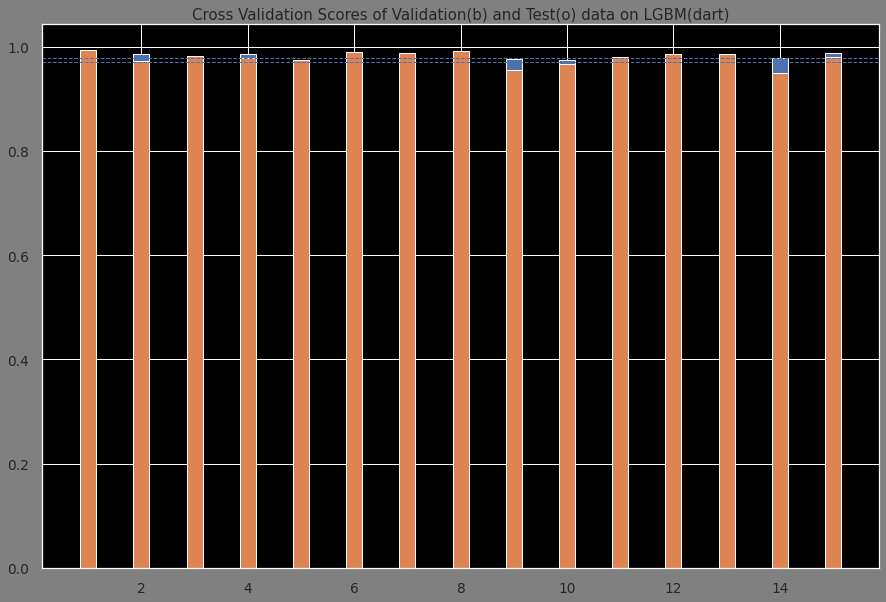

In [50]:
# Cross validation for Validation and Test data
yt = y_test.values
Xt = x_test.values
yv = y_val
Xv = x_val
cv = KFold(n_splits=15, random_state=24)
visualizer = CVScores(pipeline, cv=cv, scoring='r2',)

visualizer.fit(Xv, yv)
visualizer.set_title(title='Cross Validation Scores of Validation(b) and Test(o) data on LGBM(dart)')
visualizer.fit(Xt,yt);

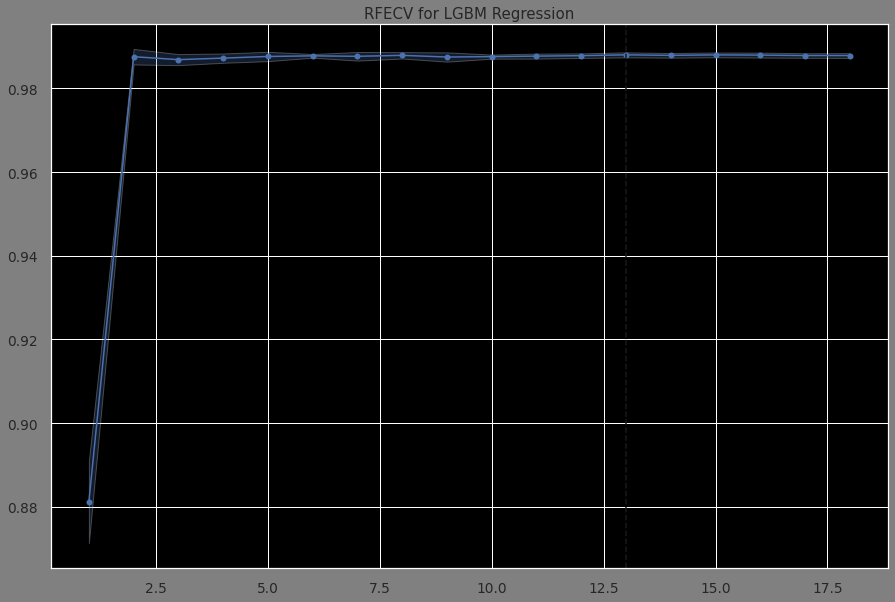

In [51]:
# Trying out something new
cv = KFold(5)
visualizer = RFECV(pipeline, cv=cv, scoring='r2')

visualizer.fit(X, y);
visualizer.set_title('RFECV for LGBM Regression')

In [52]:
# Comparing actual values to predictions of lgbm model
Comp3= pd.DataFrame()
Comp3['true_values'] = np.around(y_test)
Comp3['lgbm_prediction'] = np.around(t_pred)
Comp3

,true_values,lgbm_prediction
mp_year,,
2023,6.0,380.0
2018,5925.0,4795.0
2013,3345.0,3063.0
1953,984.0,763.0
1993,2044.0,1621.0
...,...,...
1963,713.0,661.0
1953,5482.0,5095.0
2098,785.0,1066.0


In [53]:
# Comparing actual values to baseline and favourite lasso and lgbm models
FComp = pd.DataFrame()
FComp['Actual'] = y_test
FComp['Baseline Predictions'] = testpred
FComp['New Lasso Predictions'] = lgbptpred
FComp['LGBM Predictions'] = t_pred
FComp

,Actual,Baseline Predictions,New Lasso Predictions,LGBM Predictions
mp_year,,,,
2023,5.783,7302.531799,-6511.588021,379.632058
2018,5924.969,13095.282971,2307.726861,4795.279247
2013,3344.683,11177.704703,-3.893460,3063.311920
1953,984.351,7925.102807,7761.989011,763.299686
1993,2043.621,8661.926036,7312.272830,1621.400253
...,...,...,...,...
1963,713.022,7589.789809,19149.623504,660.931769
1953,5481.696,9488.130417,16030.863708,5095.240115
2098,784.991,8785.969297,-6406.164991,1065.921989


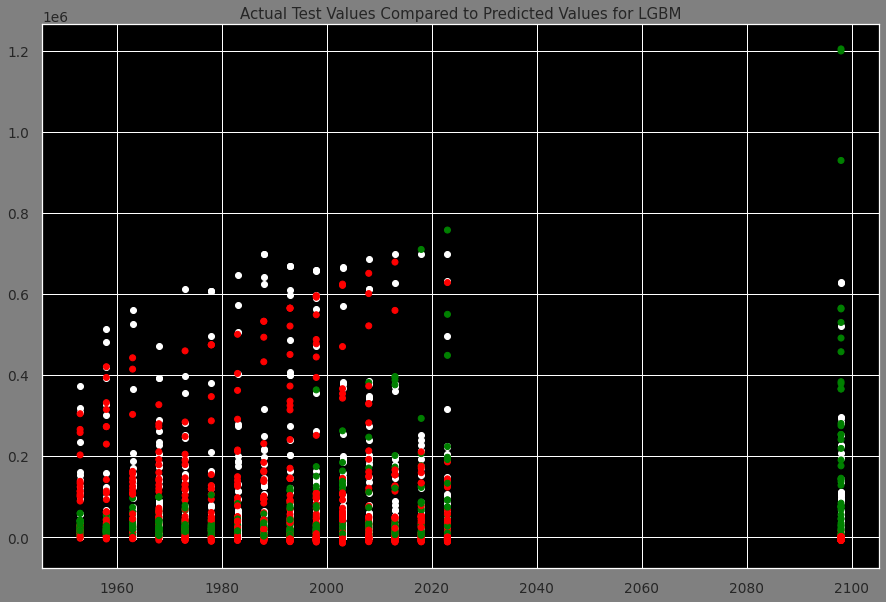

In [54]:
# The visual comparing of the lgbm predictions and the true values
# Set color 
color = ['red' if x > y else 'green' if x < y else 'white' for x,y in zip(FComp['Actual'],FComp['New Lasso Predictions'])] 
# Create scatter plot
plt.scatter(x= FComp.index, y= FComp['Actual'], c='white')
plt.scatter(x= FComp.index, y= FComp['New Lasso Predictions'],c=color)
plt.title('Actual Test Values Compared to Predicted Values for LGBM');

# **Playground:**

After finishing up initial goals the code in this area deals largely with information I need at random and testing things to that feed my curiosity. 

In [55]:
# create a pipeline with regression model for births prediction with information from Validation curves 
pipe = (LGBMRegressor(boosting_type='dart',
                          learning_rate=0.438, max_depth=-1,
                          n_estimators=26, n_jobs=-1, num_leaves=8, 
                          objective='regression',random_state=24))
pipe.fit(X_train,y_train)
Lvpred = pipe.predict(X_val)
Ltpred   = pipe.predict(X_test)
RMCViz(X_Val,y_val,valpred,x_test,y_test,Ltpred)

,Regression Metrics Model A,Regression Metrics Model B,Metrics Comparison Differences
Mean Squared Error,2255924138.999600,64708831.274110,-2191215307.725490
Root Mean Squared Error,47496.569760,8044.179960,-39452.389800
Mean Absolute Error,23332.538860,4137.018350,-19195.520520
R^2 Score,0.842090,0.995900,0.153820
Adjusted R^2,0.841950,0.995850,0.153950
Explained Variance Score,0.842430,0.995900,0.153470
Max Error,402196.417220,73797.338260,-328399.078960


In [56]:
# Using subset from earlier model
X_train

,nrr,lexmale,lexfemale,lex,mac,total_fertility,deaths,poptotal
mp_year,,,,,,,,
1963,2.300,64.86,72.15,68.81,29.062,5.050,89.612,3311.460
1963,2.230,46.09,50.60,48.32,30.542,6.200,59.282,681.633
2013,0.723,71.49,78.41,74.94,27.380,1.511,1250.418,20132.780
2008,0.843,77.93,82.15,80.10,30.606,1.750,691.913,16862.058
1993,1.906,50.49,55.64,53.01,28.812,4.939,6683.027,102203.493
...,...,...,...,...,...,...,...,...
2018,1.112,77.32,83.75,80.03,28.290,2.273,27.304,882.531
1973,1.086,69.17,75.26,72.22,27.969,2.323,2680.112,54619.240
2008,0.955,79.03,83.52,81.28,30.131,1.985,840.466,25610.449


In [57]:
Galtrea = pd.DataFrame([[3.2, x_test.nrr.mean(),78.5,72, 85,138.524,247.729,14.236,
                         56709.742,36861.33,19848.41,2.687, 11513.617,
                         x_test.sex_ratio.mean(),26.374, 3211478.217,
                         127.565,0 ]], columns=list(x_test.columns),index= ['1167'])
modelfB = Galtrea[F]
modelfB

,nrr,lexmale,lexfemale,lex,mac,total_fertility,deaths,poptotal
1167,1.49633,72,85,78.5,26.374,3.2,56709.742,3211478.217


In [58]:
modelfB['births'] = np.around(pipe.predict(Galtrea[F]),decimals=3)
modelfB

,nrr,lexmale,lexfemale,lex,mac,total_fertility,deaths,poptotal,births
1167,1.49633,72,85,78.5,26.374,3.2,56709.742,3211478.217,253463.697


## Explanatory Visualizations:
________________

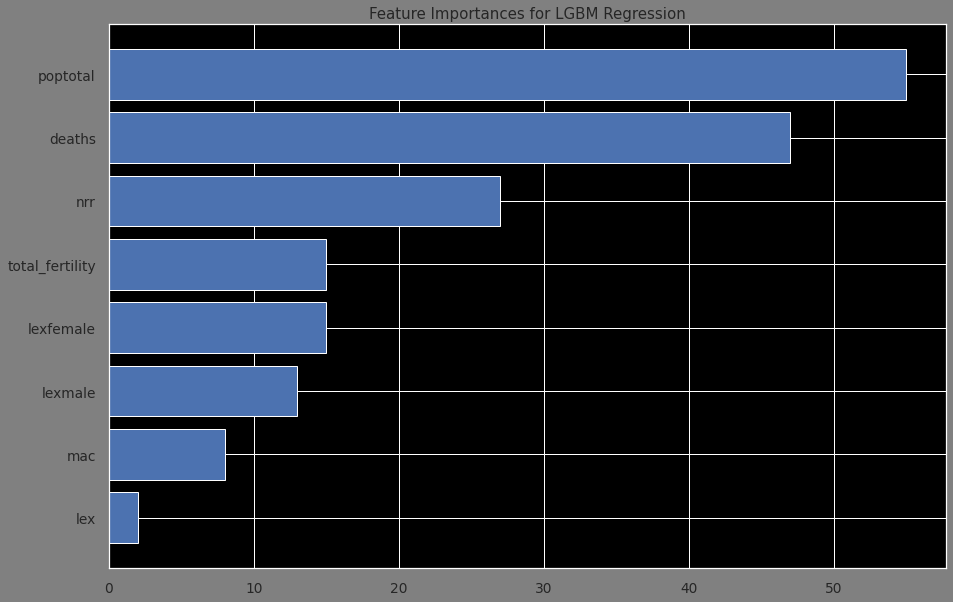

In [59]:
#visualizing pipe feature importances
visualizer = FeatureImportances(pipe,labels=F,relative=False)
visualizer.fit(X_train, y_train);
visualizer.set_title(title='Feature Importances for LGBM Regression')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


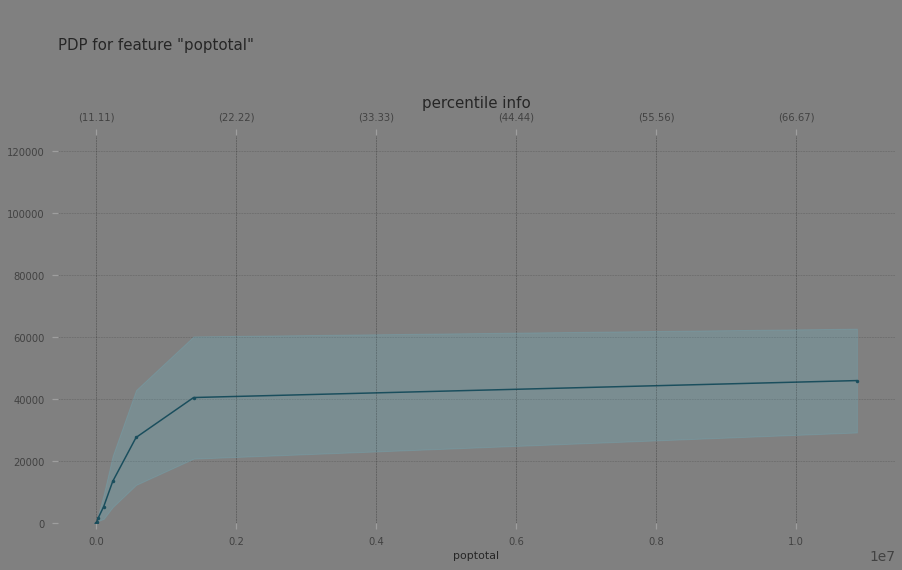

In [60]:
# pdp for poptotal in the pipeline model
feature = 'poptotal'
pdp_dist = pdp.pdp_isolate(model=pipeline, dataset=x_test, model_features=x_test.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature,show_percentile=True);